In [27]:
import pandas as pd
import numpy as np

# Load Data
def load_data(filepath):
    """Load and preprocess Google Trends and supplementary data."""
    df = pd.read_csv(filepath)
    df.rename(columns={df.columns[0]: "Week", df.columns[1]: "Interest"}, inplace=True)
    df['Week'] = pd.to_datetime(df['Week'], errors='coerce')  # Convert 'Week' column to datetime
    df['Interest'] = pd.to_numeric(df['Interest'], errors='coerce')  # Convert 'Interest' column to numeric
    return df

# Handle Missing Values
def handle_missing_values(df):
    """Handle missing values using forward fill and interpolation."""
    df['Week'] = df['Week'].ffill()  # Use forward fill directly on the Series
    df['Interest'] = df['Interest'].interpolate(method='linear')  # Interpolate 'Interest' column linearly
    df.dropna(inplace=True)  # Drop rows with any remaining NaN values
    return df

# Load and preprocess data
file_path = 'bitcoin_trends.csv'  # Change to your dataset path
df = load_data(file_path)
df = handle_missing_values(df)

# Display the first few rows of the cleaned data
print(df.head())

        Week  Interest  isPartial
0 2019-12-29        11      False
1 2020-01-05        14      False
2 2020-01-12        14      False
3 2020-01-19        13      False
4 2020-01-26        13      False


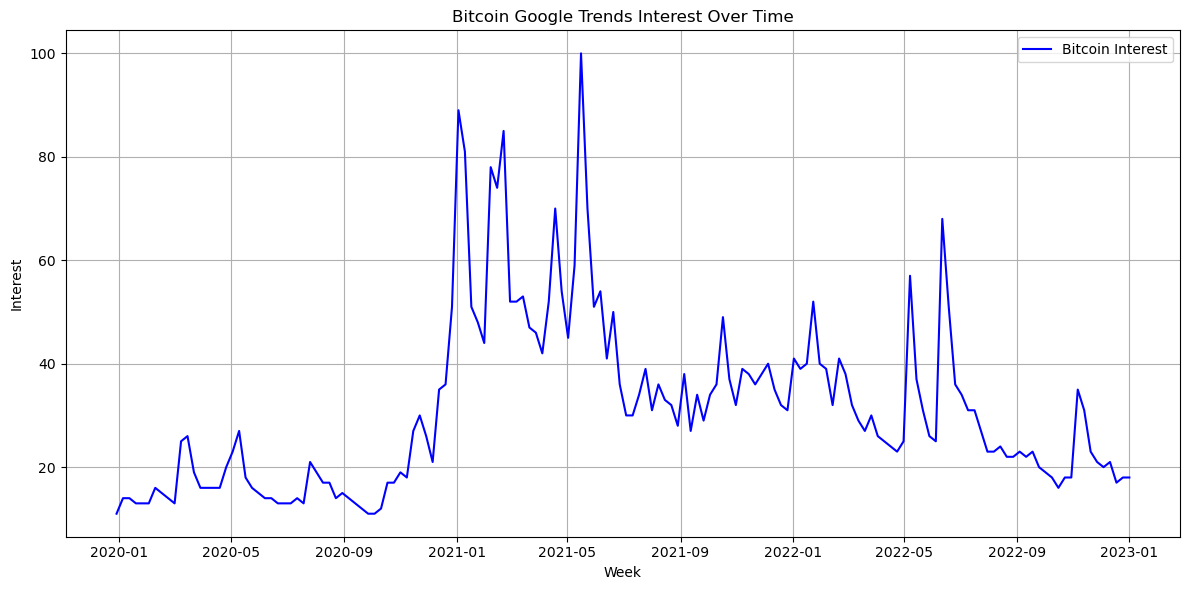

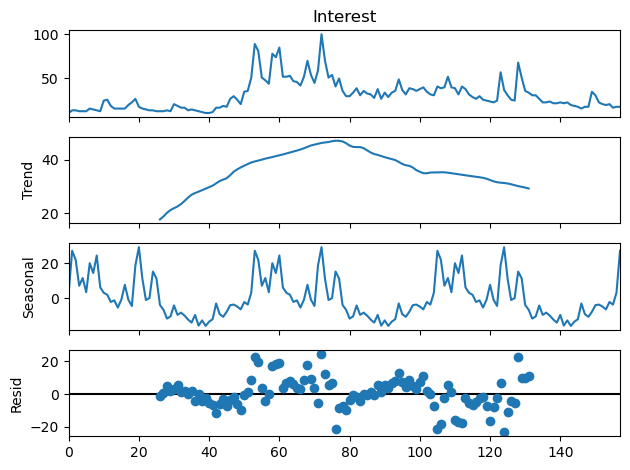

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Week'], df['Interest'], color='blue', label='Bitcoin Interest')
plt.title('Bitcoin Google Trends Interest Over Time')
plt.xlabel('Week')
plt.ylabel('Interest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Seasonal Decomposition
decompose_result = seasonal_decompose(df['Interest'], model="additive", period=52)
decompose_result.plot()
plt.tight_layout()
plt.show()

In [1]:
def create_features(df):
    """Generate rolling averages, lag features, and EMA."""
    df['Rolling_Avg_4w'] = df['Interest'].rolling(window=4).mean()
    df['EMA_4w'] = df['Interest'].ewm(span=4, adjust=False).mean()
    df['Lag_1'] = df['Interest'].shift(1)
    df['Lag_2'] = df['Interest'].shift(2)
    df['Lag_4'] = df['Interest'].shift(4)
    df.dropna(inplace=True)
    return df


In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

class LSTMConfig:
    """Configuration for LSTM training."""
    def __init__(self, epochs=20, batch_size=32, lstm_units=50, activation='relu', patience=5):
        self.epochs = epochs
        self.batch_size = batch_size
        self.lstm_units = lstm_units
        self.activation = activation
        self.patience = patience

def create_lstm_model(input_shape, lstm_units, activation):
    """Create and compile the LSTM model."""
    model = Sequential([
        LSTM(lstm_units, activation=activation, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_lstm(X_train, y_train, X_val, y_val, config):
    """Train and save an LSTM model."""
    
    # Input validation
    if X_train.ndim != 3 or X_val.ndim != 3:
        raise ValueError("X_train and X_val must be 3-dimensional arrays.")
    if y_train.ndim != 1 or y_val.ndim != 1:
        raise ValueError("y_train and y_val must be 1-dimensional arrays.")
    
    # Ensure the directory exists
    os.makedirs('results/models/', exist_ok=True)

    # Limit GPU memory usage (optional)
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_virtual_device_configuration(gpu, 
                    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        except RuntimeError as e:
            print(e)

    # Create the model
    model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), 
                               lstm_units=config.lstm_units, 
                               activation=config.activation)
    
    # Set up model checkpointing
    checkpoint_path = 'results/models/lstm_best_model.h5'
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

    # Set up early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=config.patience, restore_best_weights=True)

    try:
        model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, 
                  validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping], verbose=1)
    except Exception as e:
        print(f"An error occurred during training: {e}")
    
    # Save the final model
    model.save('results/models/lstm_model.h5')
    return model

# Example data
X_train = np.random.rand(100, 10, 1)  # 100 samples, 10 timesteps, 1 feature
y_train = np.random.rand(100)          # 100 target values
X_val = np.random.rand(20, 10, 1)      # 20 validation samples
y_val = np.random.rand(20)              # 20 validation target values

# Create configuration and train the LSTM model
config = LSTMConfig(epochs=30, batch_size=8, lstm_units=64, activation='tanh', patience=3)
lstm_model = train_lstm(X_train, y_train, X_val, y_val, config)

In [1]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

def train_xgboost(df):
    """Train and save an XGBoost regressor with hyperparameter tuning."""
    features = ['Rolling_Avg_4w', 'Lag_1', 'Lag_2', 'Lag_4']
    target = 'Interest'
    
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
    grid = GridSearchCV(XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    joblib.dump(best_model, 'results/models/xgboost_model.pkl')
    return best_model


In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance and plot predictions."""
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mape = mean_absolute_percentage_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")
    print(f"R2 Score: {r2}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label="Actual", color="blue")
    plt.plot(predictions, label="Predicted", color="red")
    plt.legend()
    plt.title("Predicted vs Actual Values")
    plt.show()
